# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

#added by me
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./traffic-signs-data/train.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# print("X_train ", X_train.shape)
# print("y_train ", y_train.shape)

# print("X_test ", X_test.shape)
# print("y_test ", X_test.shape)

# print(X_train[0].shape)

# print(len(np.unique(y_test)))

# seems this data is useless for now because the pickled data has the images already 
# cropped to fit only the traffic signs
# print(test["coords"])

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

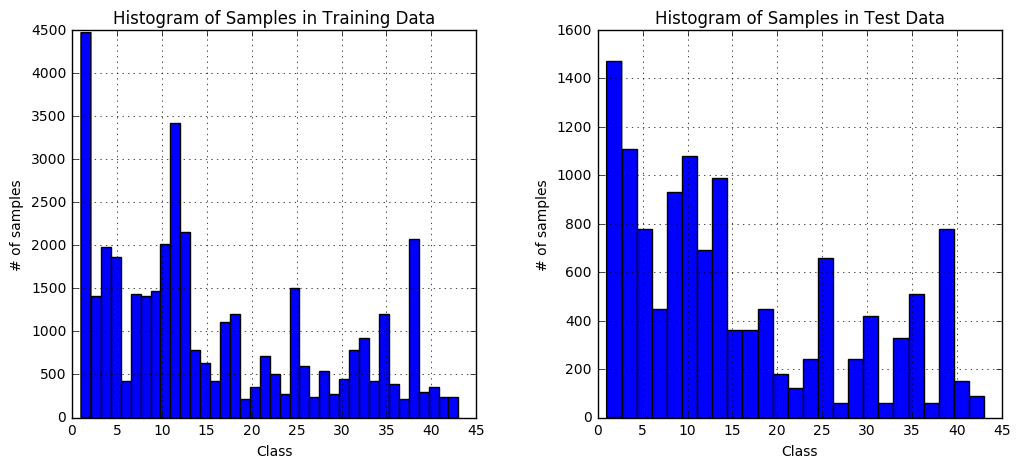

'\nit seems that some of the classes are horrifically under-represented\nwill need to apply some transformations to the images in order to make sure that there are enough\nexamples for each class in order for the CNN to classifisy future inputs properly\n'

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline

def displayHistogram(y1, y2):
    # histogram of label frequency in the training data
    f, (ax1, ax2) = plt.subplots(1, 2)

    # Fine-tune figure; make subplots spaced out
    f.subplots_adjust(wspace = .3)
    f.set_size_inches(12, 5)

    ax1.hist(y1, bins = "auto", range = (1, 43))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('# of samples')
    ax1.set_title('Histogram of Samples in Training Data')
    ax1.grid(True)

    ax2.hist(y2, bins = "auto", range = (1, 43))
    ax2.set_xlabel('Class')
    ax2.set_ylabel('# of samples')
    ax2.set_title('Histogram of Samples in Test Data')

    ax2.grid(True)

    plt.show()   
    
displayHistogram(y_train, y_test)

"""
it seems that some of the classes are horrifically under-represented
will need to apply some transformations to the images in order to make sure that there are enough
examples for each class in order for the CNN to classifisy future inputs properly
"""

In [4]:
# examples of each unique class
transform = []
classes = []

for n in range(n_classes):
    #group by class and get the first example in each group
    group = X_train[y_train == n]
    # representation = float(len(group) / n_train)
    # print(represent)
    
    # handling poor representation
    # if group is less than 2% of total sample size, will transform
    if(float(len(group) / n_train) < .02):
        transform.append(group)
        classes.append(n)
    
    # get a sample of the current class    
    # img = group[0]
    
    # display an example of each image 
    # f, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.imshow(img)
    # plt.show()
    # the code below will give you a histogram of the pixels in each image
    # ax2.hist(img.ravel(), bins=256, range = (0, 255))
    # plt.show()
    
# there are 19 imbalances in this dataset
# will need to transform all 26 classes so that there are atleast 900 examples of each
print(len(transform), " classes are imbalanced. Will need to transform the samples for these classes.")
print(len(classes), " classes are imbalanced. Will need to transform the samples for these classes.")

26  classes are imbalanced. Will need to transform the samples for these classes.
26  classes are imbalanced. Will need to transform the samples for these classes.


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Notes from \"Traffic Sign Recognition with Multi-Scale Convolutional Networks\" by Pierre Sermanet and Yann LeCun
(Exact quotes)

Data Preparation:

All images are down-sampled or upsampled to 32x32 (dataset samples sizes vary from 15x15 to 250x250) and converted 
to YUV space. The Y channel is then preprocessed with global and local contrast normalization while U and V channels
are left unchanged. Global normalization first centers each image around its mean value, whereas local 
normalization emphasizes edges.

Additionally, we build a jittered dataset by adding 5 transformed versions of the original training set, yielding
126,750 samples in total. Samples are randomly perturbed in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and
rotation ([-15,+15] degrees).

ConvNets architectures have built-in invariance to small translations, scaling and rotations. When a dataset does 
not naturally contain those deformations,adding them synthetically will yield more robust learning to potential 
deformations in the test set

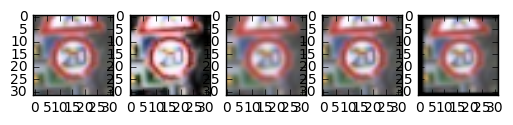

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# creating modified versions of each class in order to tackle the problem of imbalance
# will double the amount of samples present for each class

# going to use opencv to modify the images
import cv2

def normalize(img):
    #enhancing the contrast
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    # convert the YUV image back to RGB format
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    # image normalization
    #(32 x 32 x 3)
    return cv2.normalize(rgb, np.zeros((32, 32, 3)), 0, 255, cv2.NORM_MINMAX)
    # plt.imshow(normalized)
    # plt.show()

def noisy(img):
    # randomly perturbed images
    kernel = np.ones((2,2),np.float32)/4
    return cv2.filter2D(img,-1,kernel)
    # plt.imshow(noisy)
    # plt.show()

def rotate(img):
    #rotations of image in range -15 to 15
    deg = np.random.uniform(-15, 15, size=1)
    rows = cols = img.shape[0]
    rot = cv2.getRotationMatrix2D((cols/2,rows/2), deg, 1)
    return cv2.warpAffine(img,rot,(cols,rows))
    # plt.imshow(rot)
    # plt.show()

def scale(img):
    #scale image [.9,1.1] ratio
    deg = np.random.uniform(0.9, 1.1, size=1)
    # resize = cv2.resize(img, (32,32), dst=np.zeros((32, 32, 3)), fx = deg, fy = deg)
    size = 32 * deg
    start1 = np.random.uniform(0, 32-size, size=1)
    start2 = np.random.uniform(0, 32-size, size=1)
    pts1 = np.float32([[start1, start2], [start1+size, start2], [start1, start2+size], [start1+size, start2+size]])
    pts2 = np.float32([[0, 0], [32, 0], [0, 32], [32, 32]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, M, (32,32))
    # print(resize.shape)
    # plt.imshow(resize)
    # plt.show()
    # print(img == resize
    
def display(img):
    # displaying the original and the 4 new transformations
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    ax1.imshow(img)
    ax2.imshow(normalize(img))
    ax3.imshow(noisy(img))
    ax4.imshow(rotate(img))
    ax5.imshow(scale(img))

# gonna display an example of how I'm transforming the data set
display(X_train[0])

This is where I am going to transform the samples in the 9 different classes.

In [6]:
#these lists will hold the modified images
modified_Xtrain = []
modified_ytrain = []

for n in range(len(transform)):
    # print(classes[n])
    for img in transform[n]:
        modified_Xtrain.append(normalize(img))
        modified_Xtrain.append(noisy(img))
        modified_Xtrain.append(rotate(img))
        modified_Xtrain.append(scale(img))
        
        modified_ytrain.append(classes[n])
        modified_ytrain.append(classes[n])
        modified_ytrain.append(classes[n])
        modified_ytrain.append(classes[n])

modified_Xtrain = np.array(modified_Xtrain)
modified_ytrain = np.array(modified_ytrain)
print(len(modified_Xtrain), " new samples in modified_Xtrain of shape", modified_Xtrain.shape)
print(len(modified_ytrain), " new samples in modified_ytrain of shape", modified_ytrain.shape)

41996  new samples in modified_Xtrain of shape (41996, 32, 32, 3)
41996  new samples in modified_ytrain of shape (41996,)


Appending the new dataset to the original training set

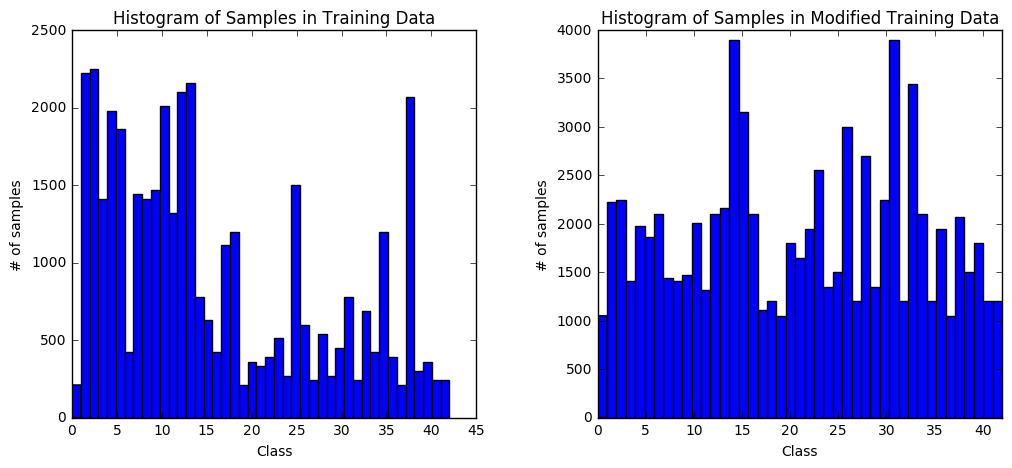


The new Input Dataset has 81205 samples in it, which has a shape of (81205, 32, 32, 3)
The new Label Dataset has 81205 samples in it, which has a shape of (81205,)


In [7]:
# print(type(y_train))
# print(type(modified_ytrain))
new_ytrain = np.append(y_train, modified_ytrain)
new_Xtrain = np.concatenate((X_train, modified_Xtrain), axis=0)
# print(np.bincount(y_train))
# print(np.bincount(modified_ytrain))
# print(np.bincount(new_train))
# print(len(np.unique(new_train)))
# print(y_train.shape)
# print(modified_ytrain.shape)
# print(new_train.shape)
# displayHistogram(y_train, new_train)
f, (ax1, ax2) = plt.subplots(1, 2)

# Fine-tune figure; make subplots spaced out
f.subplots_adjust(wspace = .3)
f.set_size_inches(12, 5)

ax1.hist(y_train, bins=43)
ax1.set_xlabel('Class')
ax1.set_ylabel('# of samples')
ax1.set_title('Histogram of Samples in Training Data')
    
ax2.hist(new_ytrain, bins=43)
ax2.set_xlabel('Class')
ax2.set_ylabel('# of samples')
ax2.set_title('Histogram of Samples in Modified Training Data')
plt.xlim([0,42])
plt.show()

print()

print("The new Input Dataset has", len(new_Xtrain), "samples in it, which has a shape of", new_Xtrain.shape)
print("The new Label Dataset has", len(new_ytrain), "samples in it, which has a shape of", new_ytrain.shape)

Need to Shuffle and Split the New Training Sets into a CV and Training Set 

In [8]:

from sklearn.utils import shuffle

new_Xtrain, new_ytrain = shuffle(new_Xtrain, new_ytrain)
X_train = np.array(new_Xtrain)
y_train = np.array(new_ytrain)

# print(type(new_Xtrain))
# print(type(new_ytrain))

print("The Shuffled Input Dataset has", len(X_train), "samples in it, which has a shape of", X_train.shape)
print("The Shuffled Label Dataset has", len(y_train), "samples in it, which has a shape of", y_train.shape)


The Shuffled Input Dataset has 81205 samples in it, which has a shape of (81205, 32, 32, 3)
The Shuffled Label Dataset has 81205 samples in it, which has a shape of (81205,)


Going to parition the datasets

In [9]:
# the above code has already shuffled everything
# the following code will also shulle everything as it partitions everyting into the CV and Training Sets
from sklearn.model_selection import train_test_split

X_train, X_CV, y_train, y_CV = train_test_split(X_train, y_train, test_size=0.2, random_state=2017)

# print(len(X_train))
# print(len(y_train))

# print(len(X_CV))
# print(len(y_CV))

# print(X_train.shape)
# print(y_train.shape)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [11]:
# going to define the variables for the CNN here
EPOCHS = 10
BATCH_SIZE = 128
learning_rate = 0.001

In [12]:
#setting up weights and bias here
mu = 0
sigma = 0.1

weights = {
    "wc1": tf.Variable(tf.truncated_normal(shape = [5, 5, 3, 6], mean = mu, stddev = sigma)),
    "wc2": tf.Variable(tf.truncated_normal(shape = [5, 5, 6, 16], mean = mu, stddev = sigma)),
    "wc3": tf.Variable(tf.truncated_normal(shape = [5, 5, 16, 400], mean = mu, stddev = sigma)),
    "wd1": tf.Variable(tf.truncated_normal(shape = [6400, 120], mean = mu, stddev = sigma)),
    "wd2": tf.Variable(tf.truncated_normal(shape = [120, 84], mean = mu, stddev = sigma)),
    "out": tf.Variable(tf.truncated_normal(shape = [84, n_classes], mean = mu, stddev = sigma))
}
bias = {
    "bc1": tf.Variable(tf.truncated_normal(shape = [6], mean = mu, stddev = sigma)),
    "bc2": tf.Variable(tf.truncated_normal(shape = [16], mean = mu, stddev = sigma)),
    "bc3": tf.Variable(tf.truncated_normal(shape = [400], mean = mu, stddev = sigma)),
    "bd1": tf.Variable(tf.truncated_normal(shape = [120], mean = mu, stddev = sigma)),
    "bd2": tf.Variable(tf.truncated_normal(shape = [84], mean = mu, stddev = sigma)),
    "out": tf.Variable(tf.truncated_normal(shape = [n_classes], mean = mu, stddev = sigma))
}

Defining helper methods below

In [13]:
# method for applying a convolution on an input
def conv2d(X, W, b, strides = 1):
    X = tf.nn.conv2d(X, W, strides=[1, strides, strides, 1], padding="SAME")
    X = tf.nn.bias_add(X, b)
    return tf.nn.relu(X)

# method for maxpooling
def maxpool2d(X, k = 2):
    return tf.nn.max_pool(X, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = "SAME")

# during training keep_prob should be 0.5 to train a mroe robust model and 1.0 during testing
# takes fully connected layers only
def dropout(X, keep_prob = 0.75):
    return tf.nn.dropout(X, keep_prob)

#only need the once before i create fully collected layers

def fully_connected(X, W, b):
    X = tf.add(tf.matmul(X, W), b)
    return tf.nn.relu(X)

Will be putting all the methods and values together below

In [14]:
def CNN(X):
    # convolution layers
    
    #layer 1
    # Input = 32x32x3 Output = 28x28x6
    conv1 = conv2d(X, weights["wc1"], bias["bc1"])
    # Input = 28x28x6. Output = 14x14x6
    conv1 = maxpool2d(conv1)
    print("conv2: ", conv1.get_shape())
    
    #layer 2
    # Input = 14x14x6 Output = 10x10x16
    conv2 = conv2d(conv1, weights["wc2"], bias["bc2"])
    # Input = 10x10x16. Output = 5x5x16
    conv2 = maxpool2d(conv2)
    
    print("conv2: ", conv2.get_shape())
    
    #layer 3
    conv3 = conv2d(conv2, weights["wc3"], bias["bc3"])
    conv3 = maxpool2d(conv3)
    
    print("conv3: ", conv2.get_shape())

    #flatten
    # flat = flatten(conv2, weights["wd1"])
    flat = flatten(conv3)
    print("flat: ", flat.get_shape())
    
    # fully connected layers
    #layer 1
    fc1 = fully_connected(flat,  weights["wd1"], bias["bd1"])
    fc1 = dropout(fc1, keep_prob=0.5)
    print("fc1: ", fc1.get_shape())
    
    #layer 2
    fc2 = fully_connected(fc1,  weights["wd2"], bias["bd2"])
    fc2 = dropout(fc2, keep_prob=0.5)
    print("fc2: ", fc2.get_shape())
    
    #output layer or logits
    return tf.add(tf.matmul(fc2, weights["out"]), bias["out"])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [16]:
X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

Training Pipeline

In [17]:
logits = CNN(X)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

conv2:  (?, 16, 16, 6)
conv2:  (?, 8, 8, 16)
conv3:  (?, 8, 8, 16)
flat:  (?, 6400)
fc1:  (?, 120)
fc2:  (?, 84)


Model Evaluation

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training the Model

In [ ]:
import os

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={X: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_CV, y_CV)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.5f}".format(validation_accuracy))
        print()
    
    
    saver.save(sess, './model/model1.ckpt')
    print("Model saved")

Training...





### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.